**Goal: Have a way to benchmark kernels doing the same operation**

In [1]:
import torch

import triton
import triton.language as tl

from triton_util import * # pip install triton-util

In [10]:
# example triton kernel
@triton.jit
def copy_k(x_ptr, y_ptr, n: tl.constexpr):
    offs = get_1d_offset(n)
    mask = get_1d_mask(offs, n)
    x = tl.load(x_ptr + offs, mask)
    tl.store(y_ptr + offs, x, mask)

@triton.jit
def copy_slow_k(x_ptr, y_ptr, n: tl.constexpr):
    offs = get_1d_offset(n)
    mask = get_1d_mask(offs, n)
    x = tl.load(x_ptr + offs, mask)
    # store same data 4 times
    tl.store(y_ptr + offs, x, mask)
    tl.store(y_ptr + offs, x, mask)
    tl.store(y_ptr + offs, x, mask)
    tl.store(y_ptr + offs, x, mask)

The below cell currently fails, presumibly due to some torch installation issue 😒

In [ ]:
# example cuda kernel, h/t Jeremy Howard
from torch.utils.cpp_extension import load_inline

def load_cuda(cuda_src, cpp_src, funcs, opt=False, verbose=False):
    return load_inline(cuda_sources=[cuda_src], cpp_sources=[cpp_src], functions=funcs,
                       extra_cuda_cflags=["-O2"] if opt else [], verbose=verbose, name="inline_ext")

cuda_begin = r'''
#include <torch/extension.h>
#include <stdio.h>
#include <c10/cuda/CUDAException.h>

#define CHECK_CUDA(x) TORCH_CHECK(x.device().is_cuda(), #x " must be a CUDA tensor")
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous(), #x " must be contiguous")
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)

inline unsigned int cdiv(unsigned int a, unsigned int b) { return (a + b - 1) / b;}
'''

cuda_src = cuda_begin + r'''
__global__ void copy_kernel(const float* x_ptr, float* y_ptr, int n) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < n) {
        y_ptr[idx] = x_ptr[idx];
    }
}

void copy(const float* x_ptr, float* y_ptr, int n) {
    copy_kernel<<<1, n>>>(x_ptr, y_ptr, n);
    cudaDeviceSynchronize();
}
'''

cpp_src = "torch::Tensor copy(torch::Tensor x, torch::Tensor y, int n);"

module = load_cuda(cuda_src, cpp_src, ['copy'], verbose=True)

Using /teamspace/studios/this_studio/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
The input conditions for extension module inline_ext have changed. Bumping to version 1 and re-building as inline_ext_v1...
Detected CUDA files, patching ldflags
Emitting ninja build file /teamspace/studios/this_studio/.cache/torch_extensions/py310_cu121/inline_ext/build.ninja...
Building extension module inline_ext_v1...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=inline_ext_v1 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/include -isystem /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/include/torch/csrc/api/include -isystem /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/include/TH -isystem /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /home/zeus/miniconda3/envs/cloudspace/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -c /teamspace/studios/this_studio/.cache/torch_extensions/py310_cu121/inline_ext/main.cpp -o main.o 
[2/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=inline_ext_v1 -DTORCH_API_INCLUDE_EXTENS

Loading extension module inline_ext_v1...


ImportError: /teamspace/studios/this_studio/.cache/torch_extensions/py310_cu121/inline_ext/inline_ext_v1.so: undefined symbol: _Z4copyN2at6TensorES0_i

In [11]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],
        x_vals=[2**i for i in range(5, 12, 1)],
        x_log=True,
        line_arg='method',
        line_vals=['pytorch', 'triton', 'triton-slow'],# 'cuda'],
        line_names=['PyTorch', 'Triton', 'Triton SLow'],# 'Cuda'],
        styles=[('blue', '-'), ('green', '-'), ('green','--')], # (orange,'-')],
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='copy-performance',
        args={}, # Values for function arguments not in `x_names` and `y_name`. -- todo: pass kernel function?
    ))
def benchmark(size, method):
    x = torch.ones(4, device='cuda')
    y = torch.ones(4, device='cuda')
    quantiles = [0.5, 0.2, 0.8]    
    if method == 'pytorch':      ms, min_ms, max_ms = triton.testing.do_bench(lambda: y.copy_(x), quantiles=quantiles)
    if method == 'triton':       ms, min_ms, max_ms = triton.testing.do_bench(lambda: copy_k[(1,)](x,y,x.numel()), quantiles=quantiles)
    if method == 'triton-slow':  ms, min_ms, max_ms = triton.testing.do_bench(lambda: copy_slow_k[(1,)](x,y,x.numel()), quantiles=quantiles)
    #if method == 'cuda':     ms, min_ms, max_ms = triton.testing.do_bench(lambda: module.copy(x,y,x.numel()), quantiles=quantiles)
    gbps = lambda ms: 12 * size / ms * 1e-6
    return gbps(ms), gbps(max_ms), gbps(min_ms)

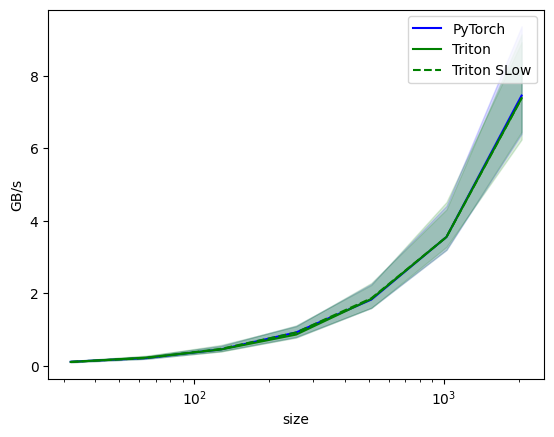

copy-performance:
     size   PyTorch    Triton  Triton SLow
0    32.0  0.113744  0.108108     0.111628
1    64.0  0.216216  0.228571     0.216216
2   128.0  0.457143  0.452830     0.470588
3   256.0  0.923077  0.864865     0.923077
4   512.0  1.828571  1.846154     1.864078
5  1024.0  3.555556  3.555556     3.555556
6  2048.0  7.456311  7.384615     7.384615


In [12]:
benchmark.run(print_data=True, show_plots=True)